In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
hotel = pd.read_csv("R2_final_hotels.csv")

In [3]:
#TotalRevenue
hotel['TotalRevenue'] = hotel['AverageDailyRate'] * (hotel['StaysInWeekendNights'] + hotel['StaysInWeekNights'])

In [4]:
#Upgrade
def decide_whether_upgrade(row):
    if row['AssignedRoom'] != row['ReservedRoom']:
        return 0
    else:
        return 1
hotel["Upgrade"] = hotel.apply(decide_whether_upgrade,axis=1)

In [5]:
UpgradeLevel = {'A': 1, 
                'B': 2, 
                'C': 3, 
                'D': 4, 
                'E': 5,
                'F': 6}

# Replace values in the AssignedRoom and ReservedRoom columns
hotel['AssignedRoom'] = hotel['AssignedRoom'].map(UpgradeLevel)
hotel['ReservedRoom'] = hotel['ReservedRoom'].map(UpgradeLevel)

def cal_upgrade_level(row):
    return row['AssignedRoom'] - row['ReservedRoom']
    
hotel['UpgradeLevel'] = hotel.apply(cal_upgrade_level, axis=1)

In [15]:
numerical_columns = hotel.select_dtypes(include=['int64', 'float64'])
numerical_columns = numerical_columns.drop(['TravelAgent', 'BookingCompany'], axis=1)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputed_data = imputer.fit_transform(numerical_columns)

numerical_columns_imputed = pd.DataFrame(imputed_data, columns=numerical_columns.columns)

kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the KMeans model on the imputed DataFrame
kmeans.fit(numerical_columns_imputed)

# Retrieve the cluster labels
clusters = kmeans.labels_

# Add the cluster labels to the DataFrame
numerical_columns_imputed['Cluster'] = clusters

# Print the mean values of numerical columns for each cluster
print(numerical_columns_imputed.groupby('Cluster').mean())

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         ArrivalWeekNumber  AssignedRoom  AverageDailyRate  BookingChanges  \
Cluster                                                                      
0                32.609449      1.238949         85.668624        0.129684   
1                29.271648      2.070891        119.059841        0.215610   
2                29.482706      2.774524        151.450114        0.257599   
3                27.683989      3.295183        176.010295        0.376404   
4                29.317513      1.730536         91.862272        0.192095   

         BookingParking  DaysInWaitingList    LeadTime  NumberOfAdult  \
Cluster                                                                 
0              0.006386           7.602542  306.820202       1.900489   
1              0.028243           0.805859   84.369739       1.926746   
2              0.030867           0.252940   93.472342       2.065215   
3              0.029494           0.000000   83.376404       2.021067   
4              

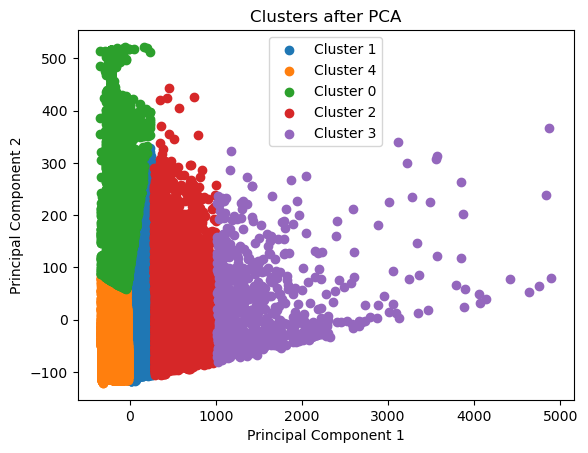

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = numerical_columns_imputed.drop('Cluster', axis=1)

pca = PCA(n_components=2)

features_pca = pca.fit_transform(features)

pca_df = pd.DataFrame(data=features_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = numerical_columns_imputed['Cluster']

for cluster in pca_df['Cluster'].unique():
    cluster_subset = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_subset['Principal Component 1'], cluster_subset['Principal Component 2'], label=f'Cluster {cluster}')

plt.title('Clusters after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

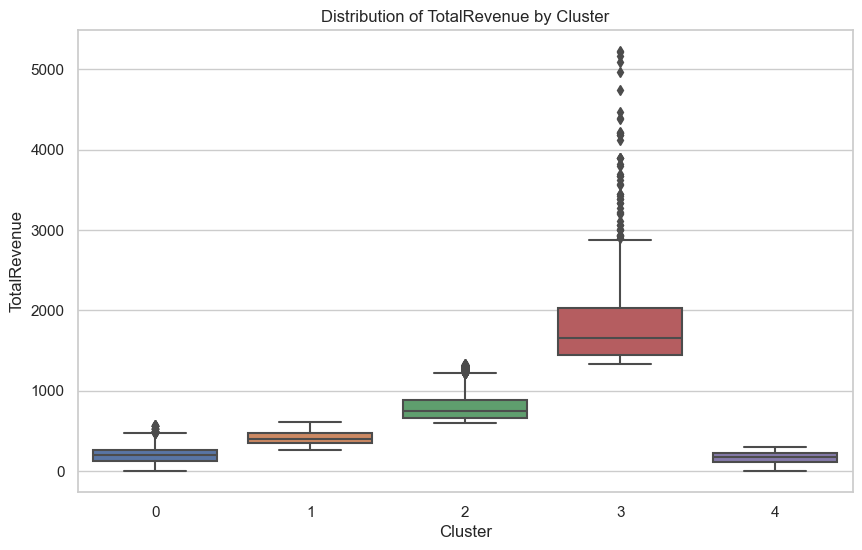

In [18]:
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a boxplot to show the distribution of TotalRevenue by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='TotalRevenue', data=numerical_columns_imputed)
plt.title('Distribution of TotalRevenue by Cluster')
plt.xlabel('Cluster')
plt.ylabel('TotalRevenue')
plt.show()

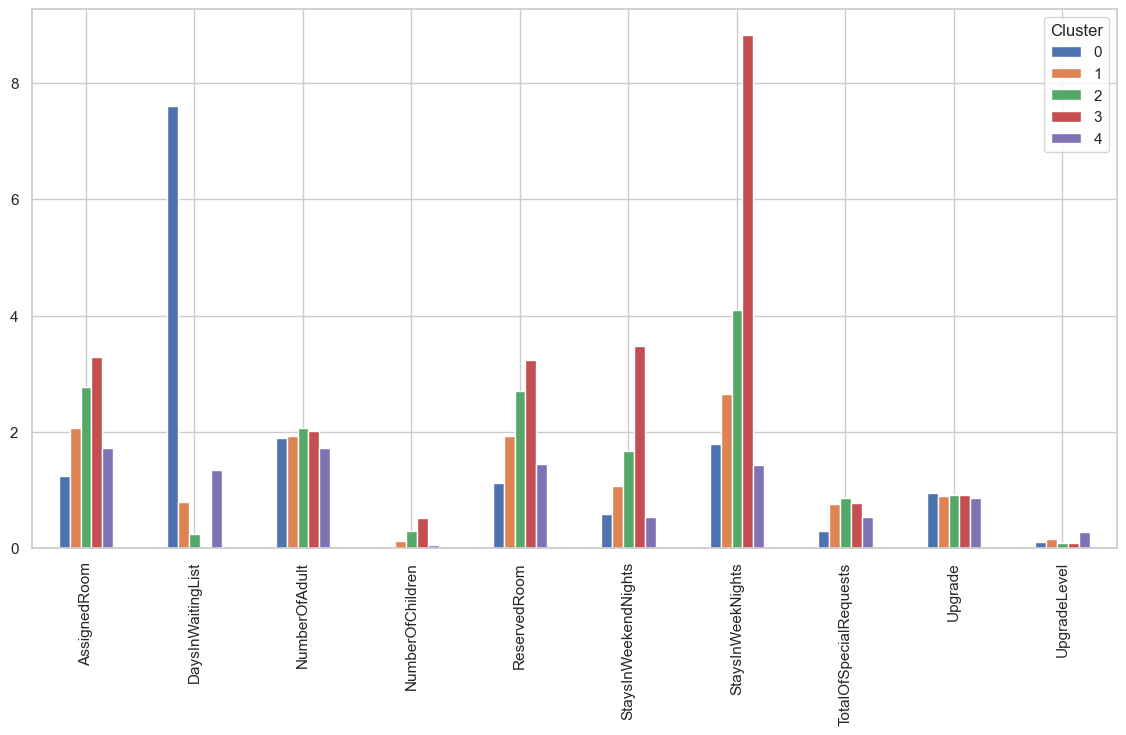

In [19]:
# Drop the specified columns and 'TotalRevenue' before grouping and calculating means
columns_to_exclude = ['TotalRevenue','BookingChanges', 'ArrivalWeekNumber', 'AverageDailyRate', 'LeadTime','BookingParking','NumberOfBabies','RepeatedGuest','PreviousCancellations','PreviousBookingsNotCanceled']
cluster_means_excluding_specific = numerical_columns_imputed.drop(columns=columns_to_exclude, axis=1).groupby('Cluster').mean()

# Transpose the DataFrame for easier plotting
cluster_means_excluding_specific_transposed = cluster_means_excluding_specific.T

# Plot the mean values for each cluster, excluding the specified columns
cluster_means_excluding_specific_transposed.plot(kind='bar', figsize=(14, 7))

plt.savefig('cluster_means_excluding_specific.png')

In [26]:
def run_logistic_regression_for_each_segment_and_get_coefficients(data, segment_col, target_col, features):
    scaler = StandardScaler()
    segments = data[segment_col].unique()
    results = {}
    coefficients = {}
    
    for segment in segments:
        print(f"Running Logistic Regression for {segment}")
        
        segment_data = data[data[segment_col] == segment]
        X = segment_data[features]
        y = segment_data[target_col]
        
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        # Store results
        results[segment] = {'Accuracy': accuracy, 'ROC AUC': roc_auc}
        
        # Store coefficients
        coefficients[segment] = dict(zip(features, model.coef_[0]))
        
        print(f"Results for {segment}: Accuracy = {accuracy:.4f}, ROC AUC = {roc_auc:.4f}\n")
    
    return results, coefficients
    
results, coeffs = run_logistic_regression_for_each_segment_and_get_coefficients(numerical_columns_imputed, 'Cluster', 'Upgrade', features)

for segment, coefs in coeffs.items():
    print(f"Segment {segment} influential factors for an upgrade:")
    sorted_coefs = sorted(coefs.items(), key=lambda x: abs(x[1]), reverse=True)
    for feature, coef in sorted_coefs:
        print(f"{feature}: {coef:.4f}")
    print("\n")

Running Logistic Regression for 1
Results for 1: Accuracy = 0.9058, ROC AUC = 0.6168

Running Logistic Regression for 4
Results for 4: Accuracy = 0.8648, ROC AUC = 0.6394

Running Logistic Regression for 0
Results for 0: Accuracy = 0.9524, ROC AUC = 0.6595

Running Logistic Regression for 2
Results for 2: Accuracy = 0.9069, ROC AUC = 0.6286

Running Logistic Regression for 3
Results for 3: Accuracy = 0.9065, ROC AUC = 0.6237

Segment 1 influential factors for an upgrade:
ArrivalWeekNumber: -0.2235
BookingChanges: -0.1552
NumberOfChildren: -0.1494
PreviousCancellations: 0.0910
NumberOfAdult: -0.0536
NumberOfBabies: -0.0390
PreviousBookingsNotCanceled: -0.0335
AverageDailyRate: 0.0295
RepeatedGuest: -0.0183
TotalOfSpecialRequests: 0.0063


Segment 4 influential factors for an upgrade:
ArrivalWeekNumber: -0.2313
AverageDailyRate: 0.1956
BookingChanges: -0.1911
PreviousCancellations: 0.1648
NumberOfChildren: -0.1540
RepeatedGuest: -0.0736
TotalOfSpecialRequests: 0.0709
PreviousBookingsNotC